# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание проекта

**Требуется определить, где бурить новую скважину.**

**В нашем распоряжении имеются пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой Bootstrap.**

**Шаги для выбора локации:**

- **В избранном регионе ищут месторождения, для каждого определяют значения признаков;**

- **Строят модель и оценивают объём запасов;**

- **Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;**

- **Прибыль равна суммарной прибыли отобранных месторождений.**

# Содержание проекта

## Загрузка и подготовка данных


- Импортируем необходимые библиотеки.

- Загружаем данные по геологоразведке для всех трёх регионов.

- Данные по первому региону. Данные по второму региону. Данные по третьему региону.

- Построим визуализации, чтобы лучше понять распределение значений в каждом регионе.

## Обучение и проверка модели

- Разделим данные на обучающую и валидационную выборки в пропорции 75:25.

- Обучим модель и спрогнозируем значения для валидационной выборки.

- Сохраним полученные прогнозы вместе с реальными значениями.

- Выведем среднее предсказанное количество сырья и RMSE модели.

- Проведем анализ полученных результатов.

## Подготовка к расчёту прибыли

- Все ключевые значения для расчётов сохранить в отдельных переменных.

- Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.

- Написать выводы для подготовки расчёта прибыли.

## Создадим функцию для расчёта прибыли на основе отобранных скважин и прогнозов модели

- Отбираем скважины с наивысшими предсказанными значениями.

- Суммируем целевые объёмы нефти, соответствующие этим прогнозам.

- Рассчитываем прибыль, исходя из общего объёма сырья.

## Расчёт прибыли и рисков 

- Применим технику Bootstrap с использованием 1000 выборок для определения распределения прибыли.

- Рассчитаем среднее значение прибыли, 95%-й доверительный интервал и оценим вероятность убытков (отрицательной прибыли).

- Сделаем выводы: выберем оптимальный регион для бурения и обоснуем этот выбор.

# 1. Загрузка и подготовка данных

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score 

STATE = np.random.RandomState(42)
TEST_SIZE=0.25


In [2]:
file_paths = ['/datasets/geo_data_0.csv', '/datasets/geo_data_1.csv', '/datasets/geo_data_2.csv']

urls = [
    'https://code.s3.yandex.net/datasets/geo_data_0.csv',
    'https://code.s3.yandex.net/datasets/geo_data_1.csv',
    'https://code.s3.yandex.net/datasets/geo_data_2.csv'
]

dfs = []

for file_path, url in zip(file_paths, urls):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
    else:
        df = pd.read_csv(url)
    dfs.append(df)

df0, df1, df2 = dfs

In [3]:
def describe_dataframe(df):
    print("Первые 10 строк набора данных:")
    display(df.head(10))
    
    print('_' * 80, '\nИнформация о наборе данных:')
    display(df.info())
    
    print('_' * 80, '\nСтатистическая сводка (включая медиану):')
    display(df.describe(percentiles=[0.5]).T)
    
    duplicate_count = df.duplicated().sum()
    print('_' * 80, f"\nКоличество дубликатов: {duplicate_count}")
    
    if duplicate_count > 0:
        print(f"Внимание: обнаружено {duplicate_count} дубликатов!")
    
    print('_' * 80, '\nГистограммы распределения данных:')
    df.hist(figsize=(15, 7), bins=50, color='black')


In [4]:
def corr_matrix(df):
    # Выводим матрицу корреляций
    print("Матрица корреляций данных:")
    corr_matrix = df.corr()
    display(corr_matrix)
    
    print("\nТепловая карта корреляций:")
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="magma", ax=ax)
    
    # Добавим заголовок и покажем график
    ax.set_title("Тепловая карта корреляций", fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


Первые 10 строк набора данных:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


________________________________________________________________________________ 
Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

________________________________________________________________________________ 
Статистическая сводка (включая медиану):


,count,mean,std,min,50%,max
f0,100000.0,0.500419,0.871832,-1.408605,0.502360,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,0.250252,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,2.515969,16.003790
product,100000.0,92.500000,44.288691,0.000000,91.849972,185.364347


________________________________________________________________________________ 
Количество дубликатов: 0
________________________________________________________________________________ 
Гистограммы распределения данных:


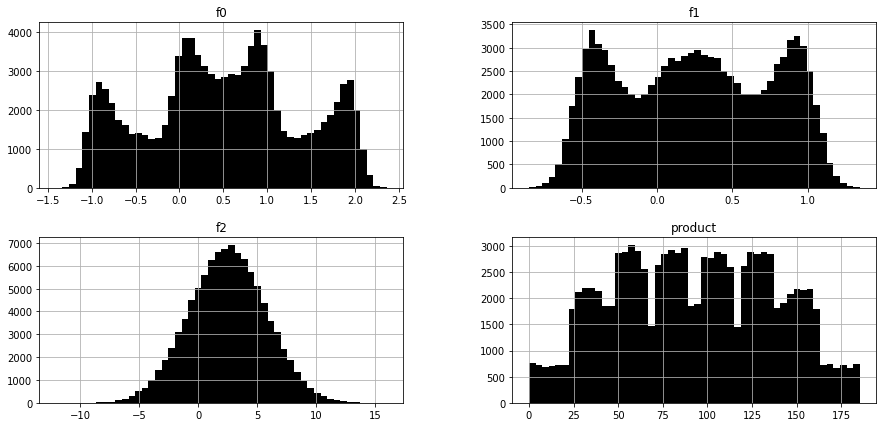

In [5]:
describe_dataframe(df0)

In [6]:
def check_id_uniqueness(df):
    # Проверяем на наличие дубликатов по столбцу id
    duplicate_ids = df['id'].duplicated().sum()
    
    if duplicate_ids > 0:
        print(f"обнаружено {duplicate_ids} дублирующихся id")
        print("Дублирующиеся записи:")
        display(df[df['id'].duplicated(keep=False)])
    else:
        print("Все id уникальны, дубликаты не обнаружены.")


In [7]:
# Проверяем уникальность id в каждом из датасетов
print("Проверка уникальности ID для df0:")
check_id_uniqueness(df0)

print("\nПроверка уникальности ID для df1:")
check_id_uniqueness(df1)

print("\nПроверка уникальности ID для df2:")
check_id_uniqueness(df2)


Проверка уникальности ID для df0:
обнаружено 10 дублирующихся id
Дублирующиеся записи:


,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205



Проверка уникальности ID для df1:
обнаружено 4 дублирующихся id
Дублирующиеся записи:


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044



Проверка уникальности ID для df2:
обнаружено 4 дублирующихся id
Дублирующиеся записи:


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


In [8]:
# Для df0
df0 = df0.loc[df0.groupby('id')['product'].idxmax()]

# Для df1
df1 = df1.loc[df1.groupby('id')['product'].idxmax()]

# Для df2
df2 = df2.loc[df2.groupby('id')['product'].idxmax()]


Матрица корреляций данных:


,f0,f1,f2,product
f0,1.000000,-0.440730,-0.003203,0.143508
f1,-0.440730,1.000000,0.001760,-0.192346
f2,-0.003203,0.001760,1.000000,0.483662
product,0.143508,-0.192346,0.483662,1.000000



Тепловая карта корреляций:


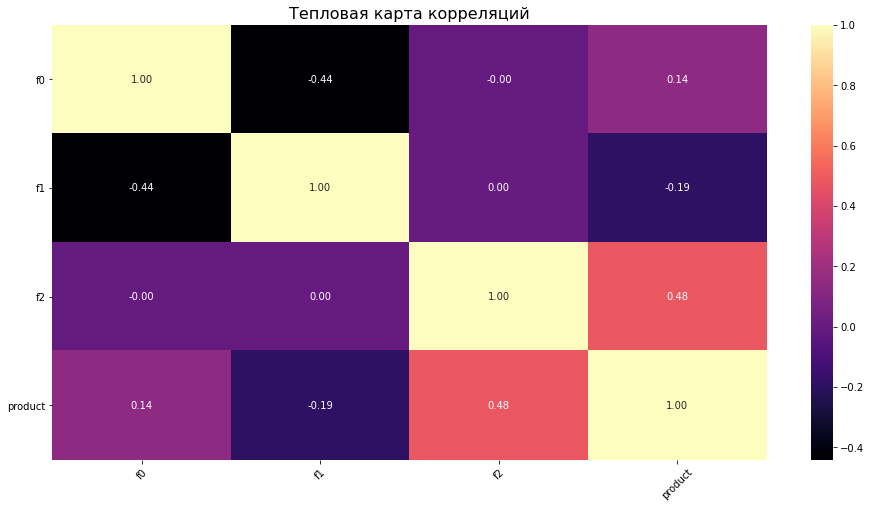

In [9]:
corr_matrix(df0)

Первые 10 строк набора данных:


,id,f0,f1,f2,product
79058,0022J,-1.757135,-8.432343,1.999313,53.906522
92381,003Gl,2.862304,-2.622592,1.999858,57.085625
14828,003Vx,3.480454,-16.404208,3.000960,80.859783
76401,004LG,5.632612,5.149203,3.004665,80.859783
20545,006oG,-4.954731,-11.776300,5.001760,137.945408
12213,008Zq,-8.150049,-7.282106,0.999069,30.132364
54272,00DUS,-10.505622,-2.174379,0.010245,3.179103
97084,00Fc3,-7.980383,-10.563682,4.996394,137.945408
18547,00Fmx,5.429347,-5.940010,2.995016,80.859783
67455,00HtC,-4.638493,-4.662175,1.006089,30.132364


________________________________________________________________________________ 
Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 79058 to 27003
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


None

________________________________________________________________________________ 
Статистическая сводка (включая медиану):


,count,mean,std,min,50%,max
f0,99996.0,1.141619,8.965953,-31.609576,1.153350,29.421755
f1,99996.0,-4.796476,5.119908,-26.358598,-4.813005,18.734063
f2,99996.0,2.494571,1.703585,-0.018144,2.011480,5.019721
product,99996.0,68.825739,45.944818,0.000000,57.085625,137.945408


________________________________________________________________________________ 
Количество дубликатов: 0
________________________________________________________________________________ 
Гистограммы распределения данных:


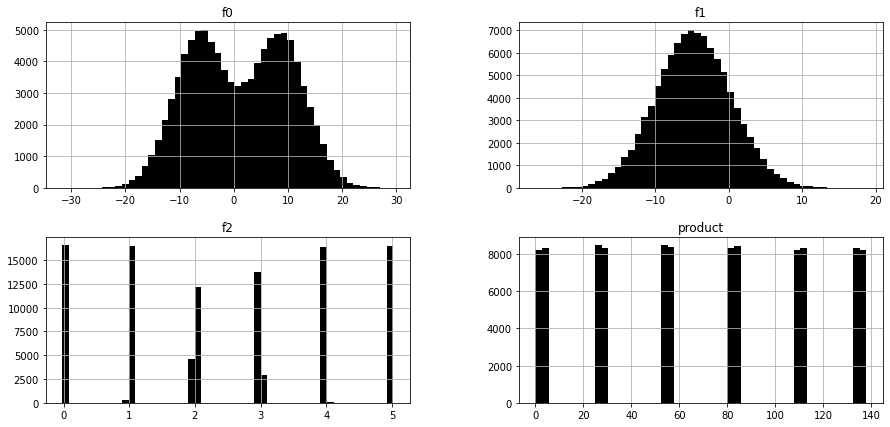

In [10]:
describe_dataframe(df1)

Матрица корреляций данных:


,f0,f1,f2,product
f0,1.000000,0.182278,-0.001796,-0.030509
f1,0.182278,1.000000,-0.002609,-0.010168
f2,-0.001796,-0.002609,1.000000,0.999397
product,-0.030509,-0.010168,0.999397,1.000000



Тепловая карта корреляций:


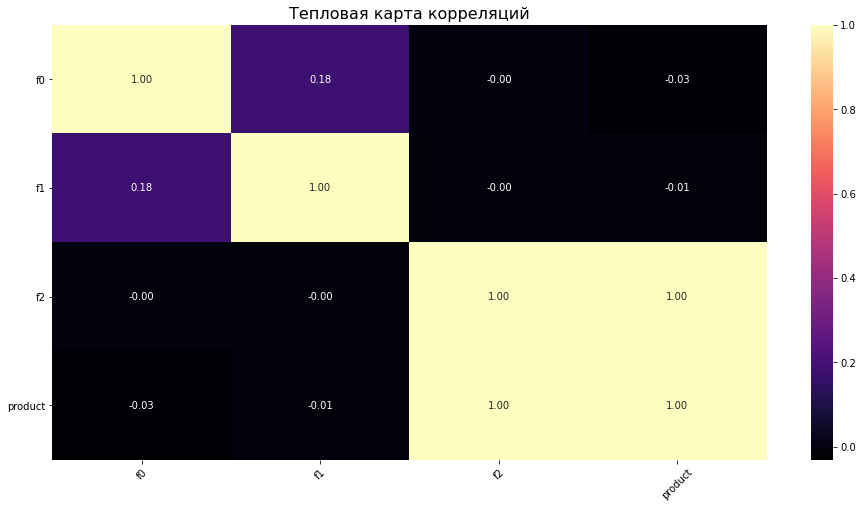

In [11]:
corr_matrix(df1)

Первые 10 строк набора данных:


,id,f0,f1,f2,product
68760,009Gl,0.557780,-1.771009,4.646146,130.621072
41673,00AuD,0.896418,0.296979,6.032145,112.891391
11522,00CaL,-1.022474,-0.744512,4.243409,132.792852
60440,00Cby,-1.183997,2.327663,2.691216,97.174303
74799,00NQN,-1.476102,0.455868,2.025839,85.888480
95796,00NhF,1.216645,0.523453,3.435961,47.605896
79279,00QNS,0.479007,-2.880751,5.264769,132.163234
37956,00aA3,1.793775,0.550489,0.367073,19.536303
19797,00c6N,1.665609,1.790063,0.885207,81.396249
86920,00eQE,3.878907,-0.366133,2.844216,120.228060


________________________________________________________________________________ 
Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 68760 to 3442
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


None

________________________________________________________________________________ 
Статистическая сводка (включая медиану):


,count,mean,std,min,50%,max
f0,99996.0,0.001987,1.732050,-8.760004,0.009411,7.238262
f1,99996.0,-0.002093,1.730431,-7.084020,-0.009580,7.844801
f2,99996.0,2.495169,3.473466,-11.970335,2.484256,16.739402
product,99996.0,95.001336,44.748968,0.000000,94.925994,190.029838


________________________________________________________________________________ 
Количество дубликатов: 0
________________________________________________________________________________ 
Гистограммы распределения данных:


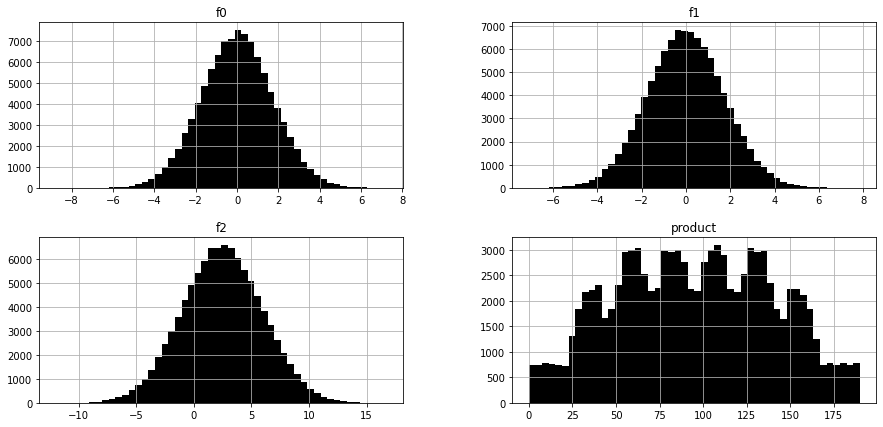

In [12]:
describe_dataframe(df2)

Матрица корреляций данных:


,f0,f1,f2,product
f0,1.000000,0.000512,-0.000438,-0.001960
f1,0.000512,1.000000,0.000790,-0.001029
f2,-0.000438,0.000790,1.000000,0.445886
product,-0.001960,-0.001029,0.445886,1.000000



Тепловая карта корреляций:


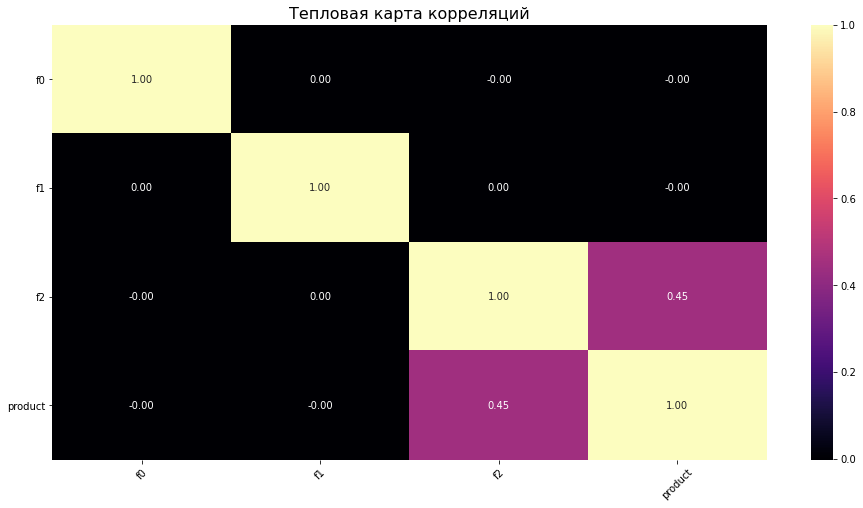

In [13]:
corr_matrix(df2)

**Вывод:**
**В трёх наборах данных дубликатов не обнаружено. По числовым показателям можно сказать, что средние значения и медианы почти не отличаются, кроме столбца product в первом наборе. Но наблюдается большой разброс значений, что видно по стандартному отклонению, особенно в столбцах f0, f1 и f2. Гистограммы показывают, что распределение переменных в разных регионах сильно разнится. В первом наборе данных заметны аномалии в столбцах f2 и product, которые могут усложнить обучение модели.**

# 2. Обучение и проверка модели

In [14]:
# Преобразуем колонку 'id' в индекс
df0.set_index('id', inplace=True)
df1.set_index('id', inplace=True)
df2.set_index('id', inplace=True)


In [15]:
# Для df0
target_0 = df0['product']
features_0 = df0.drop(columns=['product'])

# Для df1
target_1 = df1['product']
features_1 = df1.drop(columns=['product'])

# Для df2
target_2 = df2['product']
features_2 = df2.drop(columns=['product'])


In [16]:
# Разделяем данные на обучающую и валидационную выборки для df0
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=TEST_SIZE, random_state=STATE
)

# Рассчитываем доли объектов в валидационной и обучающей выборках
validation_ratio_0 = len(target_valid_0) / len(target_0)
train_ratio_0 = len(target_train_0) / len(target_0)

# Выводим результаты для удобства
print(f"Доля валидационной выборки: {validation_ratio_0:.2%}")
print(f"Доля обучающей выборки: {train_ratio_0:.2%}")


Доля валидационной выборки: 25.00%
Доля обучающей выборки: 75.00%


In [17]:
# Применяем StandardScaler к обучающей и валидационной выборкам для df0
scaler_0 = StandardScaler()
features_train_0_scaled = scaler_0.fit_transform(features_train_0)  # Обучаем scaler на обучающей выборке
features_valid_0_scaled = scaler_0.transform(features_valid_0) 

In [18]:
# Разделяем данные на обучающую и валидационную выборки для df1
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=TEST_SIZE, random_state=STATE
)

# Рассчитываем доли объектов в валидационной и обучающей выборках
validation_ratio_1 = len(target_valid_1) / len(target_1)
train_ratio_1 = len(target_train_1) / len(target_1)

# Выводим результаты для удобства
print(f"Доля валидационной выборки: {validation_ratio_1:.2%}")
print(f"Доля обучающей выборки: {train_ratio_1:.2%}")


Доля валидационной выборки: 25.00%
Доля обучающей выборки: 75.00%


In [19]:
# Применяем StandardScaler к обучающей и валидационной выборкам для df1
scaler_1 = StandardScaler()
features_train_1_scaled = scaler_1.fit_transform(features_train_1)
features_valid_1_scaled = scaler_1.transform(features_valid_1)

In [20]:
# Разделяем данные на обучающую и валидационную выборки для df2
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=TEST_SIZE, random_state=STATE
)

# Рассчитываем доли объектов в валидационной и обучающей выборках
validation_ratio_2 = len(target_valid_2) / len(target_2)
train_ratio_2 = len(target_train_2) / len(target_2)

# Выводим результаты для удобства
print(f"Доля валидационной выборки: {validation_ratio_2:.2%}")
print(f"Доля обучающей выборки: {train_ratio_2:.2%}")


Доля валидационной выборки: 25.00%
Доля обучающей выборки: 75.00%


In [21]:
# Применяем StandardScaler к обучающей и валидационной выборкам для df2
scaler_2 = StandardScaler()
features_train_2_scaled = scaler_2.fit_transform(features_train_2)
features_valid_2_scaled = scaler_2.transform(features_valid_2)

In [22]:
# Инициализируем модель линейной регрессии для региона 1
linear_model_0 = LinearRegression()

# Обучаем модель на обучающих данных
linear_model_0.fit(features_train_0_scaled, target_train_0)

# Делаем предсказания на валидационной выборке
predictions_0 = linear_model_0.predict(features_valid_0_scaled)

# Вычисляем RMSE для региона 1
rmse_0 = mean_squared_error(target_valid_0, predictions_0) ** 0.5
print(f'RMSE для региона 0: {rmse_0:.2f}')

# Вычисляем коэффициент детерминации R² для региона 1
r2_0 = r2_score(target_valid_0, predictions_0)
print(f'Коэффициент детерминации (R²) для региона 0: {r2_0:.2f}')


RMSE для региона 0: 37.62
Коэффициент детерминации (R²) для региона 0: 0.28


In [23]:
# Инициализируем модель линейной регрессии для региона 2
linear_model_1 = LinearRegression()

# Обучаем модель на обучающих данных
linear_model_1.fit(features_train_1_scaled, target_train_1)

# Делаем предсказания на валидационной выборке
predictions_1 = linear_model_1.predict(features_valid_1_scaled)

# Вычисляем RMSE для региона 2
rmse_1 = mean_squared_error(target_valid_1, predictions_1) ** 0.5
print(f'RMSE для региона 1: {rmse_1:.2f}')

# Вычисляем коэффициент детерминации R² для региона 2
r2_1 = r2_score(target_valid_1, predictions_1)
print(f'Коэффициент детерминации (R²) для региона 1: {r2_1:.2f}')


RMSE для региона 1: 0.89
Коэффициент детерминации (R²) для региона 1: 1.00


In [24]:
# Инициализируем модель линейной регрессии для региона 3
linear_model_2 = LinearRegression()

# Обучаем модель на обучающих данных
linear_model_2.fit(features_train_2_scaled, target_train_2)

# Делаем предсказания на валидационной выборке
predictions_2 = linear_model_2.predict(features_valid_2_scaled)

# Вычисляем RMSE для региона 3
rmse_2 = mean_squared_error(target_valid_2, predictions_2) ** 0.5
print(f'RMSE для региона 2: {rmse_2:.2f}')

# Вычисляем коэффициент детерминации R² для региона 3
r2_2 = r2_score(target_valid_2, predictions_2)
print(f'Коэффициент детерминации (R²) для региона 2: {r2_2:.2f}')


RMSE для региона 2: 39.89
Коэффициент детерминации (R²) для региона 2: 0.20


In [25]:
# Создаём таблицу для сравнения средних предсказанных значений 
comparison_table = pd.DataFrame(index=['Средний объём предсказанного сырья', 'RMSE модели'], columns=['Регион 1', 'Регион 2', 'Регион 3'])

# Заполняем таблицу данными для каждого региона
comparison_table['Регион 1'] = predictions_0.mean(), rmse_0
comparison_table['Регион 2'] = predictions_1.mean(), rmse_1
comparison_table['Регион 3'] = predictions_2.mean(), rmse_2

# Выводим таблицу для сравнения показателей
comparison_table.columns.name = 'Регионы'
display(comparison_table)


Регионы,Регион 1,Регион 2,Регион 3
Средний объём предсказанного сырья,92.459090,68.739247,94.946385
RMSE модели,37.616311,0.890231,39.889492


**Вывод:**
**Модели были успешно обучены и оценены с использованием метрики RMSE, которая измеряет величину среднеквадратичной ошибки предсказаний. Согласно результатам в сводной таблице, можно заметить значительное различие в значениях RMSE для второго региона по сравнению с остальными. Это связано с тем, что модель обучалась на данных с практически одинаковыми значениями, из-за чего величина ошибки остаётся практически стабильной и не изменяется сильно.**

# 3. Подготовка к расчету прибыли

In [26]:
WELLS_TOTAL = 500  # количество скважин, которые исследуют в каждом регионе при разведке
TOP_WELLS_ML = 200  # число лучших скважин для разработки, выбранных с помощью модели машинного обучения
TOTAL_BUDGET = 10e9  # бюджет на разработку выбранных скважин (в тыс. рублей) для региона
INCOME_PER_BARREL = 450e3  # доход с одной тысячи баррелей сырья (в тыс. рублей)

LOSS_THRESHOLD = 2.5 / 100  # допустимый порог риска убытков


In [27]:
region_names = ['df0', 'df1', 'df2']
datasets = [df0, df1, df2]

break_even_volume = TOTAL_BUDGET / (INCOME_PER_BARREL * TOP_WELLS_ML)
print(f'Достаточный объём сырья для безубыточной разработки = {break_even_volume:.2f} тыс. баррелей.')

for name, dataset in zip(region_names, datasets):
    print()
    print(f'Средний запас в {name} регионе = {dataset["product"].mean():.2f} тыс. баррелей.')
    print(f'Процент скважин с объёмом больше чем порог = {len(dataset.query("product > @break_even_volume")) / len(dataset):.2%}')
    print(f'Количество скважин с объёмом больше чем порог = {len(dataset.query("product > @break_even_volume"))}')
    print('-' * 40)

Достаточный объём сырья для безубыточной разработки = 111.11 тыс. баррелей.

Средний запас в df0 регионе = 92.50 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 36.58%
Количество скважин с объёмом больше чем порог = 36581
----------------------------------------

Средний запас в df1 регионе = 68.83 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 16.54%
Количество скважин с объёмом больше чем порог = 16537
----------------------------------------

Средний запас в df2 регионе = 95.00 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 38.18%
Количество скважин с объёмом больше чем порог = 38177
----------------------------------------


**Вывод:**
**Для того чтобы разработка была рентабельной, выбранные скважины должны иметь запасы, значительно превышающие пороговое значение. В условиях текущей ситуации процент скважин с такими запасами во всех регионах составляет менее 40%. Точка безубыточности находится на уровне около 111.11 тыс. баррелей на скважину, в то время как средние запасы варьируются от 68 до 95 тыс. баррелей по регионам. Таким образом, из 500 исследованных скважин только 200 (или 40%) обладают объёмами, достаточными для преодоления порога.**

# 4. Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [28]:
# Для df0

# Выберем скважины с максимальными значениями предсказаний
predictions_0 = linear_model_0.predict(features_valid_0)

# Выполним привязку индексов скважин к предсказаниям модели и отсортируем список по убыванию
probs_sorted_0 = pd.Series(predictions_0, index=target_valid_0.index).sort_values(ascending=False)

# Выберем 200 скважин с наибольшими предсказаниями
selected_max_0 = probs_sorted_0[:200]
selected_max_0


id
QFDWZ    442.281268
xuWxm    428.463835
R5IYz    418.798385
lfgbR    390.490368
he3xS    388.034045
            ...    
2GvnZ    313.478288
na9uy    313.295735
bsk9y    313.125602
N3i8x    313.113015
tU6pF    313.012838
Length: 200, dtype: float64

In [29]:
# Рассчитаем суммарный объём сырья для 200 лучших скважин
top_200_sum_0 = selected_max_0.sum()
print(f'Суммарный запас сырья в 200 лучших скважинах: {top_200_sum_0:.2f} тыс. баррелей')

# Рассчитаем прибыль для полученного объёма сырья
profit_0 = (top_200_sum_0 * INCOME_PER_BARREL) - TOTAL_BUDGET
print(f'Прибыль для полученного объёма составит: {profit_0:.2f} тыс. рублей')



Суммарный запас сырья в 200 лучших скважинах: 66783.16 тыс. баррелей
Прибыль для полученного объёма составит: 20052422556.36 тыс. рублей


In [30]:
# Функция для расчёта прибыли по выбранным скважинам
def profit(predictions, targets, well_count):
    sorted_wells = pd.Series(predictions, index=targets.index).sort_values(ascending=False)
    top_well_sum = sorted_wells[:well_count].sum()
    profit = (top_well_sum * INCOME_PER_BARREL) - TOTAL_BUDGET
    print(f'Суммарный запас сырья в {well_count} лучших скважинах: {top_well_sum:.2f} тыс. баррелей')
    print(f'Прибыль для полученного объёма составит: {profit / 1000:.2f} млн. рублей')


In [31]:
profit(predictions_0,target_valid_0,200)

Суммарный запас сырья в 200 лучших скважинах: 66783.16 тыс. баррелей
Прибыль для полученного объёма составит: 20052422.56 млн. рублей


In [32]:
profit(predictions_1,target_valid_1,200)

Суммарный запас сырья в 200 лучших скважинах: 27753.40 тыс. баррелей
Прибыль для полученного объёма составит: 2489028.64 млн. рублей


In [33]:
profit(predictions_2,target_valid_2,200)

Суммарный запас сырья в 200 лучших скважинах: 29538.20 тыс. баррелей
Прибыль для полученного объёма составит: 3292188.34 млн. рублей


**Вывод:**
**Все три региона демонстрируют потенциал для получения прибыли. Для более точного определения самого выгодного региона с учётом окупаемости инвестиций и рисков убытков проведём расчёт вероятностей в следующем разделе.**

 # 5. Расчёт прибыли и рисков

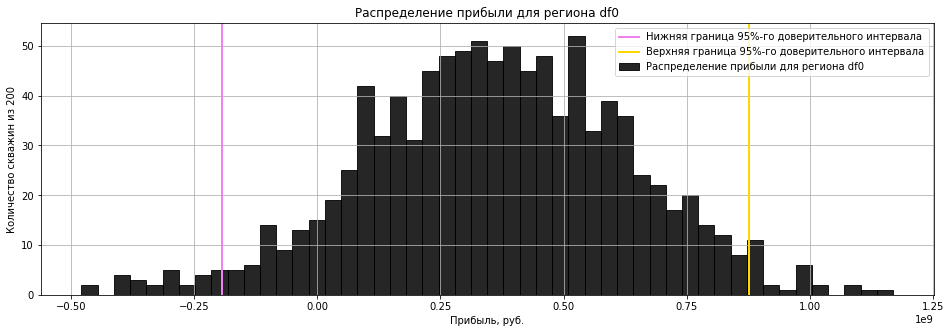

Для региона df0:
Средняя прибыль с 200 лучших скважин: 363 млн. руб.
Доверительный интервал прибыли: -193 - 876 млн. руб.
Риск убытков: 8.00%


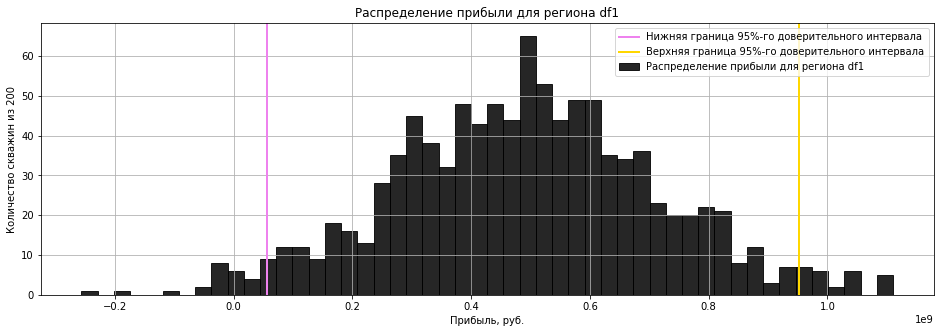

Для региона df1:
Средняя прибыль с 200 лучших скважин: 491 млн. руб.
Доверительный интервал прибыли: 56 - 952 млн. руб.
Риск убытков: 1.40%


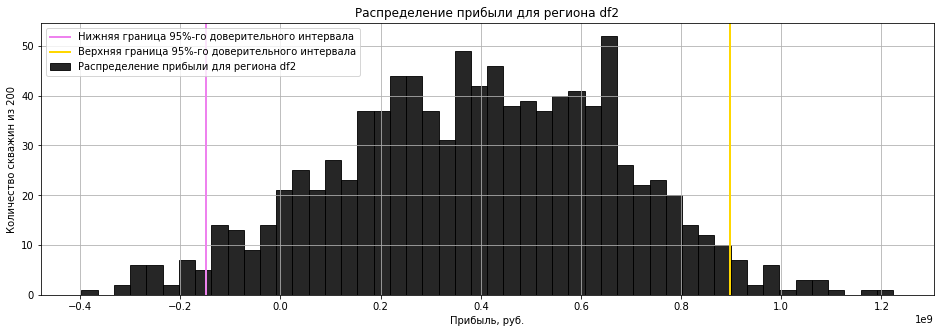

Для региона df2:
Средняя прибыль с 200 лучших скважин: 393 млн. руб.
Доверительный интервал прибыли: -148 - 898 млн. руб.
Риск убытков: 8.30%


In [34]:
# Функция для расчёта прибыли по выбранным скважинам
def calculate_profit(fact_targets, well_count):
    top_well_sum = fact_targets[:well_count].sum()
    profit = (top_well_sum * INCOME_PER_BARREL) - TOTAL_BUDGET
    return profit

# Данные по регионам
regions_data = {
    'df0': {'predictions': pd.Series(predictions_0), 'targets': target_valid_0},
    'df1': {'predictions': pd.Series(predictions_1), 'targets': target_valid_1},
    'df2': {'predictions': pd.Series(predictions_2), 'targets': target_valid_2},
}

for region_name, data in regions_data.items():
    predictions = data['predictions']
    targets = data['targets']

    predictions.index = targets.index

    
    profits = []

    # Цикл для генерации 1000 выборок с Bootstrap
    for _ in range(1000):
        # Создаем случайную подвыборку с заменой из целей (targets) и предсказаний (predictions)
        sample_indices = targets.sample(n=WELLS_TOTAL, replace=True, random_state=STATE).index
        sample_predictions = predictions.loc[sample_indices]
        sample_targets = targets.loc[sample_indices]

        # Сортируем скважины по предсказаниям, но прибыль считаем по фактическим значениям
        sorted_indices = sample_predictions.sort_values(ascending=False).index
        top_fact_targets = sample_targets.loc[sorted_indices]

        # Рассчитываем прибыль для этой подвыборки
        profit = calculate_profit(top_fact_targets, TOP_WELLS_ML)
        profits.append(profit)

    # Преобразуем список значений в Pandas Series для анализа
    profits = pd.Series(profits)

    # Рассчитываем среднее значение прибыли, доверительные интервалы и риск убытков
    mean_profit = profits.mean() / 1e6  # в млн. рублей
    lower_bound = profits.quantile(.025) / 1e6  # нижняя граница 95%-го доверительного интервала
    upper_bound = profits.quantile(.975) / 1e6  # верхняя граница 95%-го доверительного интервала
    risk_of_loss = (profits < 0).mean() * 100  # риск убытков

    # Построим гистограмму распределения прибыли для текущего региона
    plt.figure(figsize=(16, 5))
    profits.hist(bins=50, color='black', edgecolor='black', alpha=0.85)
    plt.axvline(x=lower_bound * 1e6, color='violet', linestyle='-', linewidth=2)
    plt.axvline(x=upper_bound * 1e6, color='gold', linestyle='-', linewidth=2)
    plt.xlabel('Прибыль, руб.')
    plt.ylabel('Количество скважин из 200')
    plt.title(f'Распределение прибыли для региона {region_name}')
    plt.grid(True)
    plt.legend(['Нижняя граница 95%-го доверительного интервала', 
                'Верхняя граница 95%-го доверительного интервала', 
                f'Распределение прибыли для региона {region_name}'])
    plt.show()

    # Вывод результатов для каждого региона
    print(f'Для региона {region_name}:')
    print(f'Средняя прибыль с 200 лучших скважин: {mean_profit:.0f} млн. руб.')
    print(f'Доверительный интервал прибыли: {lower_bound:.0f} - {upper_bound:.0f} млн. руб.')
    print(f'Риск убытков: {risk_of_loss:.2f}%')


**Вывод:**
**Анализ показал, что наибольшая средняя прибыль прогнозируется во втором регионе, где она составляет 491 млн. рублей, с допустимым риском убытков в 1.40%. Первый и третий регионы также показали прибыль в 363 млн. рублей и 393 млн. рублей соответственно, но риск убытков в этих регионах составляет 8.00% и 8.30%, что значительно превышает допустимый порог риска в 2.5%. Несмотря на то, что средняя прибыль в первом и третьем регионах сравнительно высока, их высокий уровень риска делает их менее привлекательными для разработки. Таким образом, второй регион является наиболее перспективным с точки зрения прибыли при приемлемом уровне риска.**

# 6. Вывод

**Мы проанализировали данные по запасам нефти в трёх регионах, каждый из которых содержал сведения о 10 тысячах скважин. Первичный анализ показал, что средний объём запасов в этих регионах не обеспечивает окупаемость затрат на разработку. Для более точного прогнозирования перспектив разработки мы обучили модель линейной регрессии и использовали метод Bootstrap, разделив предсказанные значения прибыли на 1000 выборок для каждого региона. На основании результатов мы рассчитали 95%-й доверительный интервал для прибыли и ограничили допустимый риск убытков на уровне 2.5%.**

**Анализ показал, что наибольшая средняя прибыль прогнозируется во втором регионе — 491 млн. рублей, при низком риске убытков в 1.40%. Первый и третий регионы имеют среднюю прибыль в 363 млн. рублей и 393 млн. рублей, однако риск убытков в этих регионах значительно выше — 8.00% и 8.30%. Это делает их менее привлекательными для разработки. Таким образом, второй регион выбран для дальнейшей разработки, так как он демонстрирует наибольшую прибыль при приемлемом уровне риска.**